In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device=torch.device('cpu')
learning_rate=1e-4

In [3]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/Re_100/input_u_fake.dat')
data_out=np.loadtxt('./data/Re_100/output_p.dat')
x=torch.Tensor(data_in)
y=torch.Tensor(data_out)
loader=DataLoader(TensorDataset(x, y), batch_size=204)

In [4]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
x=torch.randn(64, 6724, device=device) #Input dimension of 1000
y=torch.randn(64, 6724, device=device) #Output dimension of 10 i.e, ground-truth dimension
print(x.size())
loader=DataLoader(TensorDataset(x, y), batch_size=6724)

torch.Size([64, 6724])


In [5]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, B, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, H)
        self.linear_2=torch.nn.Linear(H, B)
        self.linear_3=torch.nn.Linear(B, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        h=self.linear_1(x)
        h_relu=torch.nn.functional.relu(h) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(h_relu) 
        b_relu=torch.nn.functional.relu(b)
        y_pred=self.linear_3(b_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6724, H=1000, B=100, D_out=6724)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [6]:
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

Epochs:  0 ; Loss:  1.0150134563446045
Epochs:  10 ; Loss:  0.9996188879013062
Epochs:  20 ; Loss:  0.9963328838348389
Epochs:  30 ; Loss:  0.9922813177108765
Epochs:  40 ; Loss:  0.9872265458106995
Epochs:  50 ; Loss:  0.9810537695884705
Epochs:  60 ; Loss:  0.973750650882721
Epochs:  70 ; Loss:  0.9652711153030396
Epochs:  80 ; Loss:  0.9555574059486389
Epochs:  90 ; Loss:  0.9446518421173096
Epochs:  100 ; Loss:  0.9326510429382324
Epochs:  110 ; Loss:  0.919552206993103
Epochs:  120 ; Loss:  0.9054200053215027
Epochs:  130 ; Loss:  0.8903639912605286
Epochs:  140 ; Loss:  0.8744727969169617
Epochs:  150 ; Loss:  0.8578102588653564
Epochs:  160 ; Loss:  0.8404197692871094
Epochs:  170 ; Loss:  0.8223000168800354
Epochs:  180 ; Loss:  0.8036009669303894
Epochs:  190 ; Loss:  0.7843625545501709
Epochs:  200 ; Loss:  0.7646484375
Epochs:  210 ; Loss:  0.744488000869751
Epochs:  220 ; Loss:  0.7240378856658936
Epochs:  230 ; Loss:  0.7033116221427917
Epochs:  240 ; Loss:  0.682450175285

Text(0, 0.5, 'loss')

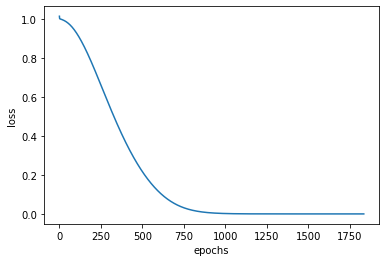

In [7]:
# Step 1. Prepare data-2/2
# Iterate over loader to form mini-batches
# Batch aims to deal with memory limitation in GPU

loss_epoch=[]
loss_values = []

for epochs in range(2000):
    # Step 3. Forward pass-2/2  
    # Feed data to model, and compute loss
    
    for x_batch, y_batch in loader:
        y_pred=model(x_batch) #為何不是 model.forward(x_batch) #Forward 過程中同時建立computational graph
        loss=torch.nn.functional.mse_loss(y_pred, y_batch) #Loss functions 是被定義在torch.nn.functional中
        
        # Step 4. Backward pass-2/2
        # Compute gradient of loss wrt all model weights
        loss.backward()
        
        # Step 5. Update Weights
        optimizer.step()
        optimizer.zero_grad() #此步為清空，否則會影響下一步gradient的計算
        if epochs%10==0:
            print("Epochs: ", epochs, "; Loss: ", loss.item())
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())

    if loss<1e-6: #stop training criterion
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        break


#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

In [8]:
PATH= "01_model_jit.pth"
traced_net=torch.jit.trace(model, torch.randn(1,6724))
torch.jit.save(traced_net, PATH)